## Can we make neural networks more confident?

### What is Overfitting?

According to Wikipedia: In overfitting, a statistical model describes random error or noise instead of the underlying relationship. Overfitting occurs when a model is **excessively complex**, such as having too many parameters relative to the number of observations. A model that has been overfitted has **poor predictive performance**, as it overreacts to minor fluctuations in the training data. 

In a supervised setting, such overfit model gives significantly high importance to what it has seen during the training and doesn't generalize well during a test or when it is actually deployed. Particularly, we observe deceivingly high training accuracy, but upsettingly low test accuracy (deployment performance). For example, in image classification problem, the model which has been overfitted learns training images so well that it is hard to distinguish learning from blindly remembering! Moreover, it gets extremely certain about what a particular class looks like, which sadly is not too different from what it has learned (or better call it remembered) during the training phase. This isn't a desirable property; when presented with 1K or 10K images of cats and dogs, we don't want it to just remember that only those set of pixels or group of pixels represent a cat or a dog class, and a slightest deviation from it is something else. This isn't learning, it is more or less remembering; it is important to understand the difference between these two terms. Remembering can be thought of as just copying, whereas learning is the ability to extract meaningful patterns or abstract concepts that generalize well. 

Overfit models pick up even the silliest details of a class, and noise which isn't representative of the general description of that class. As a result, such model assigns a high class score (probability value) to only those images which are identical or very close to one of the training images. For example, it assigns a high class score to training images, whereas a very low class score when the same image is perturbed a little (e.g., few pixels are brighter or darker than the original image), resulting in classification error. This is very impractical, as there can be a lot of variations in class images such as those due to various scales, viewpoints, deformations, illuminations, or intra-class variance. Many of these variations are inherent to a particular class, more precisely the image of it, and it is highly unlikely that such model would be tolerant of all such variations let alone issues like partial observation and other unpredicted distortions. We can say that the model is over-confident about its own understanding. 

The image below shows the difference between class boundaries resulting from an overfit model and a good one (better generalization). The green squiggly line represents a decision boundary resulting from an overfit model. As we can see, it doesn't seem to have captured a true relationship between explanatory variables (here: x & y-axis variables) and the response (blue or red class). In contrast, the black line seems a more reasonable estimate of the true relationship. The green one will definitely perform better over the training input, however, for unseen data, it is unlikely to perform better compared to the black one. 

<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/Overfitting.svg"/>
<center>Image by Ignacio Icke, distributed under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)</center>


### Overfitting in Neural Networks

Artificial Neural Networks are prone to overfitting, and there are many ways to fight it. In fact, this is one of the great challenges of deep learning and neural networks. There are many regularization methods: L1 (lasso regression), L2 (ridge regression) terms, and Maxnorm, which penalize the larger weights so they don't grow too large; DropOut, DropConnect, and Maxout techniques make neural nets disregard certain nodes or connections during forward propagation in order to reduce overfitting, by taking average (ensemble) of different models. 


### Intuition behind the need of Confidence

Where does confidence come in the picture? So far, we have seen that our enemy is overfitting i.e. over-confidence. There are various regularization techniques that can help our models stay away from overfitting the training data. Here is the intuition that might explain the notion of confidence in neural networks. In a supervised (human-human teaching) setting, let's suppose you are asked to believe/learn that horses have 3 tails. Would you easily accept it? Or would you reject it up front? Or would you be surprised and then argue endlessly? Now let's further suppose that you are “forced” to believe that it is a fact. Would that change your own (neuronal) understanding about the horse object? Absolutely you won't. More likely, you will create an association of horse object with the so called 3 tailed horse in your brain (and also the belief that you still need to work a lot before you accept this to be true for all the horses). In addition to that, you might also remember this event because it was totally counterintuitive, bizarre, and to some extent a funny experience of your life. It might also be the case that whenever you think about horses in future, you will recollect about this funny incident via association horse-> 3 tailed -> some stupid guy -> utter nonsense :) The upshot of this experiment is to show that how certain we are about basic things or concepts most of the time, and it is almost impossible to change our belief about such fundamental things. Especially those which we have learned in past very well (at least we believe so) unless something crazy is happening with the world e.g., unanimous consensus that we are actually living in the Matrix world; whatever we have learned is just an illusion, and there is actually a new finding that horses, in reality, do have three tails. Assuming that it is not the case, your "confidence" could definitely help you – not learn the wrong things! 

A wise man shouldn't be excessively certain about anything. However, for simple concepts, we all (I believe wise men too) are actually very certain–99.99 ish maybe, because we have observed such concepts repeatedly many times in our life and also confirmed through other associations. This confidence helps us stay sane, and not spend time re-learning or re-exploring concepts which are trivial (according to our understanding. Is it trivial because we have seen few horses and read about them in books and seen them in a couple of movies? Hmm.. not a foolproof fact-finding procedure I must say). Such notion of confidence is absent in Neural Networks. 

Why do we want neural networks to be confident? There are many applications we can imagine such as: 1) The training dataset contains large amount of mislabeled samples 2) In the online learning scenario where the training data is so huge to be rigorously reviewed or verified by humans 3) In representation learning where features are not interpretable, and we want the network to avoid learning wrong representations. Generally, when the network has seen enough inputs that it is okay to be confident and not learn wrong features which can foreseeably distort existing representations (beliefs).

Hey vsauce?
- How certain we are about simple concepts actually? What is the distribution of this certainty over population? 
- How many time is "many" when we talk about certainty of belief?

## Experiment: test NN confidence

Using class visualization technique, we will analyze how a simple CNN architecture behaves under the situation where it is trained with conflicting input samples. For example, what are the effects of training wrong things to a good dog classifier. How severely and how soon does it distort the belief of Neural Network about what the dog is. Essentially, we will be verifying the effect of incorrect training to its accuracy on true class. The purpose is to study if there are any undesirable consequences. 

In [1]:
import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image, preprocess_image
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.layer_utils import *
import cs231n.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from sklearn.metrics import confusion_matrix
from IPython import display

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# TinyImageNet and pretrained model

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


In [3]:
# print "tiny-imagenet-100-A classes: "
# for k, v in enumerate(data['class_names']):
#     print k,v[0],
#     if k % 6 == 5:
#         print ""

 # Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [1]; [2] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I s_y(I) + R(I)
$$

where $R$ is a (possibly implicit) regularizer. We can solve this optimization problem using gradient descent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) + \lambda \|I\|_2^2
$$

and implicit regularization as suggested by [2] by peridically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

In [4]:
def create_class_visualization(target_y, model, **kwargs):
  """
  Perform optimization over the image to generate class visualizations.
  
  Inputs:
  - target_y: Integer in the range [0, 100) giving the target class
  - model: A PretrainedCNN that will be used for generation
  
  Keyword arguments:
  - learning_rate: Floating point number giving the learning rate
  - blur_every: An integer; how often to blur the image as a regularizer
  - l2_reg: Floating point number giving L2 regularization strength on the image;
    this is lambda in the equation above.
  - max_jitter: How much random jitter to add to the image as regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the image
  """
  
  learning_rate = kwargs.pop('learning_rate', 10000)
  blur_every = kwargs.pop('blur_every', 1)
  l2_reg = kwargs.pop('l2_reg', 1e-6)
  max_jitter = kwargs.pop('max_jitter', 4)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 25)
  
  X = np.random.randn(1, 3, 64, 64)
    
  num_plots = int(np.ceil(num_iterations/show_every))

  for t in xrange(num_iterations):
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # Compute the image gradient dX of the image with respect to the     #
    # target_y class score. This should be similar to the fooling images. Also #
    # add L2 regularization to dX and update the image X using the image       #
    # gradient and the learning rate.                                          #
    ############################################################################
    scores, cache = model.forward(X)
    prediction = np.argmax(scores[0])
    
    # no need to repeat these steps in this loop
    expected_score = np.zeros_like(scores)    
    expected_score[0, target_y] = 1
    dscores = expected_score
    
    # maximization of the class posterior (normalized softmax score) : same observation as authors said, not visually prominent or intuitive
    #loss, dscores = softmax_loss(scores, target_y)
    #dx, grads = model.backward(dscores, cache)
    
    dx, grads = model.backward(dscores, cache)
    
    # gradient of the regularization 
    dx -= l2_reg * (2*X)
    X += learning_rate * dx
    
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
    # As a regularizer, periodically blur the image
    if t % blur_every == 0:
      X = blur_image(X)
    
    # Periodically show the image
    if t % show_every == 0:
      plt.subplot(int(np.sqrt(num_plots))-1, int(np.sqrt(num_plots))+2, int(t/show_every)+1)
      plt.imshow(deprocess_image(X, data['mean_image']))
        #       plt.subplot.gcf().set_size_inches(3, 3)
      plt.axis('off')
      display.clear_output(wait=True)
      display.display(plt.gcf())
  display.clear_output(wait=True)
  return X

In [5]:
Xvis_gold_ret = []
Xvis_tarantula = []
Xvis_espresso = []

### Class Visualization

Class Visualization for ['golden retriever']


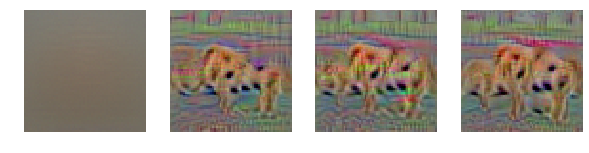

In [6]:
golden_retriever_cls_idx = 78
Xvis_gold_ret.append(create_class_visualization(golden_retriever_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][golden_retriever_cls_idx])

Class Visualization for ['tarantula']


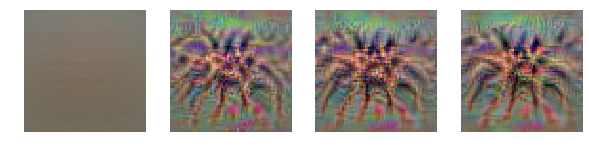

In [7]:
tarantula_cls_idx = 43
Xvis_tarantula.append(create_class_visualization(tarantula_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][tarantula_cls_idx])

Class Visualization for ['espresso']


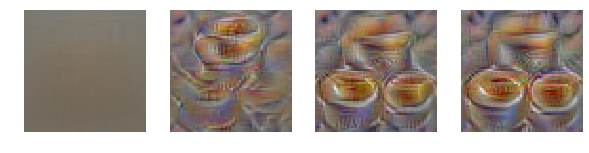

In [8]:
espresso_cls_idx = 8
Xvis_espresso.append(create_class_visualization(espresso_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][espresso_cls_idx])

In [9]:
def run_prediction(model, X, batch_size=64, print_every=100):
    
    num_samples = len(X)
    y_scores = np.zeros((num_samples, model.num_classes))
    y_prediction = np.zeros((num_samples))
    num_batches = int(np.ceil(num_samples/batch_size))
    
    print "Batch prediction start... \n Num samples: {}, Num batches: {}".format(num_samples, num_batches)
    # Run batchwise prediction
    for i in xrange(num_batches):
    
        start_idx, end_idx = i*batch_size, min((i+1)*batch_size, num_samples)
    
        if i % print_every == 0:
            print " > Running prediction: batch {}-{}/{}".format(i, min(i+print_every, num_batches), num_batches)
        
        scores,_ = model.forward(X[start_idx:end_idx])
        y_scores[start_idx:end_idx,:] = scores
        y_prediction[start_idx:end_idx] = np.argmax(scores, axis=1)
    
    print "Batch prediction finished..."
    return {'scores': y_scores, 'predictions': y_prediction}


def get_perf_stats(ground_truth, prediction, qclass=golden_retriever_cls_idx):
    
    num_samples = len(ground_truth)
    confusion_mat = confusion_matrix(ground_truth, prediction) # [ground truth x predictions]

    qclass_true = sum(confusion_mat[qclass, :])
    qclass_predicted_true = sum(confusion_mat[:, qclass])
    qclass_true_pos = confusion_mat[qclass, qclass]
    qclass_false_neg =  qclass_true - qclass_true_pos
    qclass_false_pos = qclass_predicted_true - qclass_true_pos
    qclass_true_neg = np.sum(confusion_mat)-qclass_true-qclass_false_pos
    
    perf_stats = {}

    perf_stats["overall_accuracy"] = sum(prediction == ground_truth)/float(num_samples)
    perf_stats["num_samples"] = num_samples
    perf_stats["ground_truth_pos"] = qclass_true
    perf_stats["predicted_pos"] = qclass_predicted_true
    perf_stats["true_pos"] = qclass_true_pos
    perf_stats["false_neg"] = qclass_false_neg
    perf_stats["true_neg"] = qclass_true_neg
    perf_stats["false_pos"] = qclass_false_pos
    perf_stats["cls_recall"] = qclass_true_pos/float(qclass_true_pos+qclass_false_neg)
    perf_stats["cls_precision"] = qclass_true_pos/float(qclass_true_pos+qclass_false_pos)
    
    return perf_stats
    
def print_perf_stats(ground_truth, prediction, qclass=golden_retriever_cls_idx):
    
    num_samples = len(ground_truth)
    confusion_mat = confusion_matrix(ground_truth, prediction) # [ground truth x predictions]

    qclass_true = sum(confusion_mat[qclass, :])
    qclass_predicted_true = sum(confusion_mat[:, qclass])
    qclass_true_pos = confusion_mat[qclass, qclass]
    qclass_false_neg =  qclass_true - qclass_true_pos
    qclass_false_pos = qclass_predicted_true - qclass_true_pos
    qclass_true_neg = np.sum(confusion_mat)-qclass_true-qclass_false_pos
    
    print "Overall Accuracy: {}\n".format(sum(prediction == ground_truth)/float(num_samples))
    print "\"{}\" classifier \n-----".format(data['class_names'][qclass][0])

    print " Num Samples: {}, \n\n\
 Ground Truth Positive: {} \t Predicted Positive: {}\n\
 True Positive: {} \t\t False Negative: {},\n\
 True Negative: {} \t\t False Positive: {}\n".format( num_samples, qclass_true, qclass_predicted_true, 
                                                            qclass_true_pos, qclass_false_neg, 
                                                            qclass_true_neg, qclass_false_pos )

    print " Recall: {}".format(qclass_true_pos/float(qclass_true_pos+qclass_false_neg))
    print " Precision: {}\n-----".format(qclass_true_pos/float(qclass_true_pos+qclass_false_pos))
    
def print_all_perf_stats(ground_truth, predictions, msg):
    print "*** {} ***\n".format(msg)
    print_perf_stats(ground_truth, predictions, golden_retriever_cls_idx)
    print_perf_stats(ground_truth, predictions, tarantula_cls_idx)
    print_perf_stats(ground_truth, predictions, espresso_cls_idx)
    
def plot_score_distribution(scores):

    x_range = range(len(scores))
    score_mu,score_std = np.mean(scores), np.std(scores)
    y_mean = score_mu*np.ones(len(scores))
    y_std_l, y_std_h = (score_mu-score_std)*np.ones(len(scores)), (score_mu+score_std)*np.ones(len(scores))
    
    print "Mean = {}, Std = {}".format(score_mu, score_std)

    fig,ax = plt.subplots()
    # Plot the data
    data_line = ax.scatter(x_range, scores, label='Data', zorder=1)
    # Plot the mean line
    mean_line = ax.plot(x_range, y_mean, label='Mean', linestyle='--', color='g', zorder=3, linewidth=4)
    # Plot the std dev lines
    mean_line = ax.plot(x_range, y_std_h, label='std +', linestyle='--', color='r', zorder=3, linewidth=3)
    mean_line = ax.plot(x_range, y_std_l, label='std -', linestyle='--', color='r', zorder=3, linewidth=3)

    # Make a legend
    legend = ax.legend(loc='upper right')
    plt.xlim(0, len(scores))

    plt.show()

In [10]:
model_out = {}

### Training Performance

In [11]:
model_out["tr_original"] = run_prediction(model, data['X_train'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 50000, Num batches: 781
 > Running prediction: batch 0-100/781
 > Running prediction: batch 100-200/781
 > Running prediction: batch 200-300/781
 > Running prediction: batch 300-400/781
 > Running prediction: batch 400-500/781
 > Running prediction: batch 500-600/781
 > Running prediction: batch 600-700/781
 > Running prediction: batch 700-781/781
Batch prediction finished...


In [12]:
print_all_perf_stats(data['y_train'], model_out["tr_original"]['predictions'], "Training Performance - Original")

*** Training Performance - Original ***

Overall Accuracy: 0.9069

"golden retriever" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 564
 True Positive: 450 		 False Negative: 50,
 True Negative: 49386 		 False Positive: 114

 Recall: 0.9
 Precision: 0.797872340426
-----
Overall Accuracy: 0.9069

"tarantula" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 516
 True Positive: 468 		 False Negative: 32,
 True Negative: 49452 		 False Positive: 48

 Recall: 0.936
 Precision: 0.906976744186
-----
Overall Accuracy: 0.9069

"espresso" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 514
 True Positive: 493 		 False Negative: 7,
 True Negative: 49479 		 False Positive: 21

 Recall: 0.986
 Precision: 0.959143968872
-----


Distribution of scores: 
Mean = 12.7412263811, Std = 3.26430072384


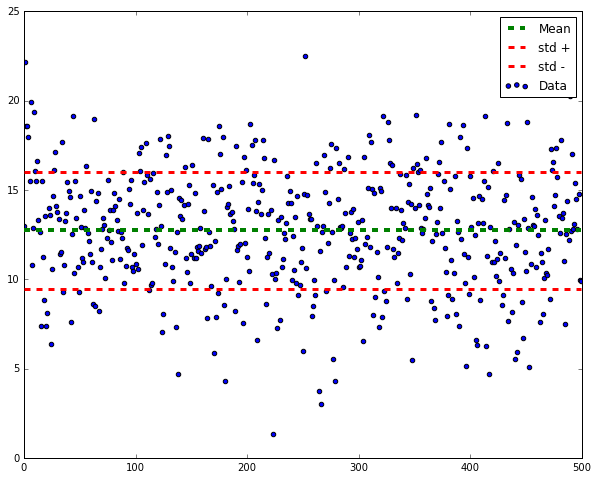

In [14]:
print "Distribution of scores: "
plot_score_distribution(model_out['tr_original']['scores'][data['y_train'] \
                                == golden_retriever_cls_idx, golden_retriever_cls_idx])

### Validation Performance

In [15]:
model_out["val_original"] = run_prediction(model, data['X_val'], batch_size=64, print_every=20)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-20/78
 > Running prediction: batch 20-40/78
 > Running prediction: batch 40-60/78
 > Running prediction: batch 60-78/78
Batch prediction finished...


In [16]:
print_all_perf_stats(data['y_val'], model_out["val_original"]['predictions'], "Validation Performance - Original")

*** Validation Performance - Original ***

Overall Accuracy: 0.5776

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 58
 True Positive: 30 		 False Negative: 20,
 True Negative: 4922 		 False Positive: 28

 Recall: 0.6
 Precision: 0.51724137931
-----
Overall Accuracy: 0.5776

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 56
 True Positive: 31 		 False Negative: 19,
 True Negative: 4925 		 False Positive: 25

 Recall: 0.62
 Precision: 0.553571428571
-----
Overall Accuracy: 0.5776

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 53
 True Positive: 38 		 False Negative: 12,
 True Negative: 4935 		 False Positive: 15

 Recall: 0.76
 Precision: 0.716981132075
-----


Distribution of scores: 
Mean = 10.6924070233, Std = 4.79898022594


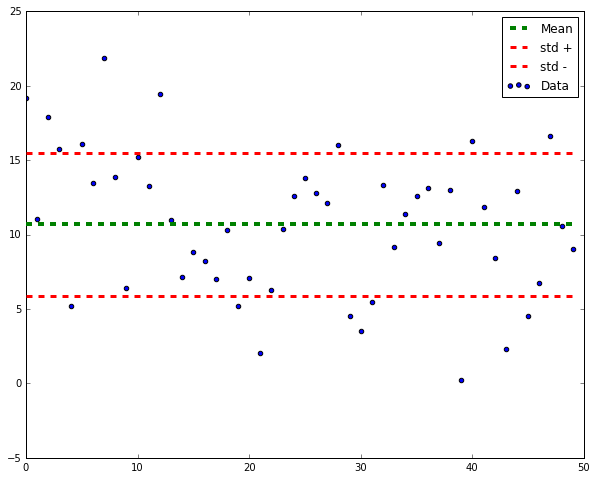

In [19]:
print "Distribution of scores: "
plot_score_distribution(model_out["val_original"]['scores'][data['y_val'] \
                            == golden_retriever_cls_idx, golden_retriever_cls_idx])

## Training with 10 incorrect images 

We will train our pre-trained model with incorrect images. Here, we will train our network with Tarantula images however with wrong label–Golden Retriever Dog. Let's see how it affects the model performance.

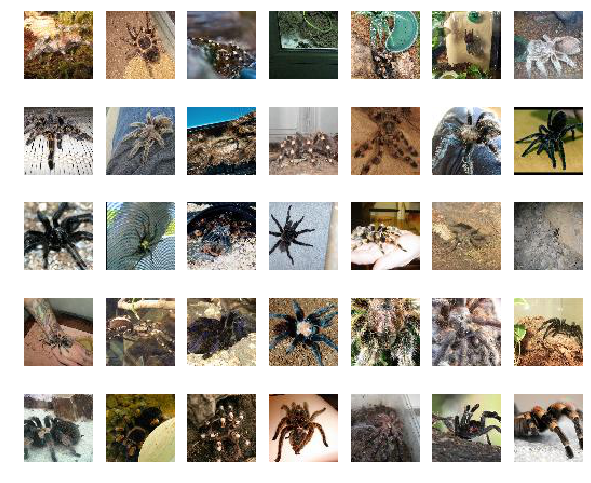

In [20]:
tarantula_cls_idx = 43
tarantula_train_images = data['X_val'][data['y_val'] == tarantula_cls_idx]

display_num = 35
plt.figure(figsize=(10,10))
for i, img in enumerate(tarantula_train_images[:display_num]):
    plt.subplot(np.ceil(np.sqrt(display_num)),np.ceil(np.sqrt(display_num))+1, i+1)
    plt.imshow((np.uint8(img + data['mean_image']).transpose(1,2,0)))
    plt.axis("off")

In [21]:
num_incorrect_train = 10
loss, grads = model.loss(tarantula_train_images[0:num_incorrect_train], golden_retriever_cls_idx)

# Perform a parameter update
config = {'learning_rate': 1e-2}
for p, w in model.params.iteritems():
    dw = grads[p]
    next_w, next_config = optim.sgd(w, dw, config)
    model.params[p] = next_w
    # not useful in sgd; for other optimization algos, this config needs to be maintained per layer
    config = next_config  

### Class Visualization

Class Visualization for ['golden retriever']


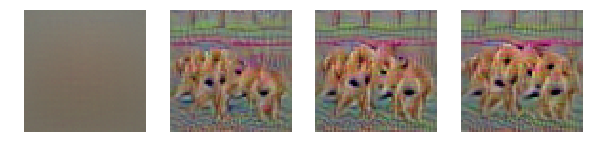

In [22]:
plt.rcParams.update({'figure.figsize': (10,8)})
Xvis_gold_ret.append(create_class_visualization(golden_retriever_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][golden_retriever_cls_idx])

Class Visualization for ['tarantula']


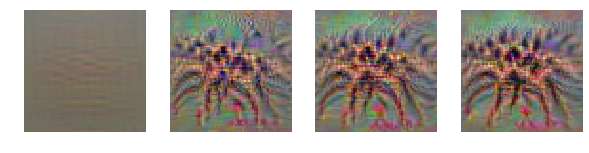

In [23]:
Xvis_tarantula.append(create_class_visualization(tarantula_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][tarantula_cls_idx])

Class Visualization for ['espresso']


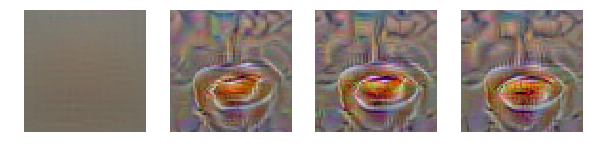

In [24]:
Xvis_espresso.append(create_class_visualization(espresso_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][espresso_cls_idx])

**Training Performance**:

In [25]:
# Prediction on training set
model_out['tr_inc_10'] = run_prediction(model, data['X_train'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 50000, Num batches: 781
 > Running prediction: batch 0-100/781
 > Running prediction: batch 100-200/781
 > Running prediction: batch 200-300/781
 > Running prediction: batch 300-400/781
 > Running prediction: batch 400-500/781
 > Running prediction: batch 500-600/781
 > Running prediction: batch 600-700/781
 > Running prediction: batch 700-781/781
Batch prediction finished...


In [26]:
print_all_perf_stats(data['y_train'], model_out["tr_inc_10"]['predictions'], "Training Performance - inc 10")

*** Training Performance - inc 10 ***

Overall Accuracy: 0.8603

"golden retriever" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 680
 True Positive: 446 		 False Negative: 54,
 True Negative: 49266 		 False Positive: 234

 Recall: 0.892
 Precision: 0.655882352941
-----
Overall Accuracy: 0.8603

"tarantula" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 512
 True Positive: 436 		 False Negative: 64,
 True Negative: 49424 		 False Positive: 76

 Recall: 0.872
 Precision: 0.8515625
-----
Overall Accuracy: 0.8603

"espresso" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 585
 True Positive: 494 		 False Negative: 6,
 True Negative: 49409 		 False Positive: 91

 Recall: 0.988
 Precision: 0.844444444444
-----


**Validation Performance**:

In [27]:
# Prediction on validation set
model_out['val_inc_10'] = run_prediction(model, data['X_val'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-78/78
Batch prediction finished...


In [28]:
print_all_perf_stats(data['y_val'], model_out["val_inc_10"]['predictions'], "Validation Performance - inc 10")

*** Validation Performance - inc 10 ***

Overall Accuracy: 0.5354

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 85
 True Positive: 33 		 False Negative: 17,
 True Negative: 4898 		 False Positive: 52

 Recall: 0.66
 Precision: 0.388235294118
-----
Overall Accuracy: 0.5354

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 42
 True Positive: 23 		 False Negative: 27,
 True Negative: 4931 		 False Positive: 19

 Recall: 0.46
 Precision: 0.547619047619
-----
Overall Accuracy: 0.5354

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 85
 True Positive: 39 		 False Negative: 11,
 True Negative: 4904 		 False Positive: 46

 Recall: 0.78
 Precision: 0.458823529412
-----


### Training with 40 incorrect images. More tarantulas disguised as dogs.

In [31]:
loss, grads = model.loss(tarantula_train_images[10:50], golden_retriever_cls_idx)

# Perform a parameter update
config = {'learning_rate': 1e-2}
for p, w in model.params.iteritems():
    dw = grads[p]
    next_w, next_config = optim.sgd(w, dw, config)
    model.params[p] = next_w
    # not useful in sgd; for other optimization algos, this config needs to be maintained per layer
    config = next_config  

Class Visualization for ['golden retriever']


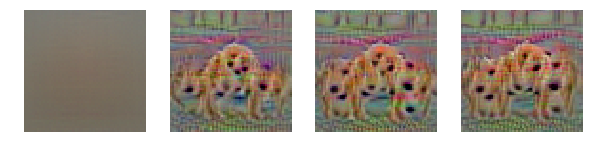

In [33]:
golden_retriever_cls_idx = 78
plt.rcParams.update({'figure.figsize': (10,8)})
Xvis_gold_ret.append(create_class_visualization(golden_retriever_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][golden_retriever_cls_idx])

Class Visualization for ['tarantula']


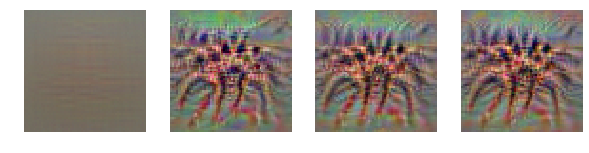

In [34]:
Xvis_tarantula.append(create_class_visualization(tarantula_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][tarantula_cls_idx])

Class Visualization for ['espresso']


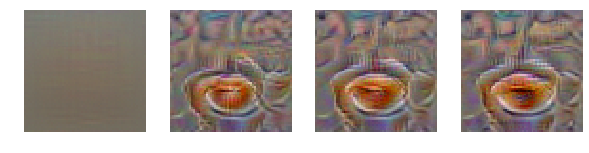

In [35]:
Xvis_espresso.append(create_class_visualization(espresso_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][espresso_cls_idx])

**Training Performance:**

In [36]:
model_out['tr_inc_50'] = run_prediction(model, data['X_train'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 50000, Num batches: 781
 > Running prediction: batch 0-100/781
 > Running prediction: batch 100-200/781
 > Running prediction: batch 200-300/781
 > Running prediction: batch 300-400/781
 > Running prediction: batch 400-500/781
 > Running prediction: batch 500-600/781
 > Running prediction: batch 600-700/781
 > Running prediction: batch 700-781/781
Batch prediction finished...


In [37]:
print_all_perf_stats(data['y_train'], model_out["tr_inc_50"]['predictions'], "Training Performance - inc 50")

*** Training Performance - inc 50 ***

Overall Accuracy: 0.85748

"golden retriever" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 687
 True Positive: 465 		 False Negative: 35,
 True Negative: 49278 		 False Positive: 222

 Recall: 0.93
 Precision: 0.676855895197
-----
Overall Accuracy: 0.85748

"tarantula" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 490
 True Positive: 440 		 False Negative: 60,
 True Negative: 49450 		 False Positive: 50

 Recall: 0.88
 Precision: 0.897959183673
-----
Overall Accuracy: 0.85748

"espresso" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 607
 True Positive: 495 		 False Negative: 5,
 True Negative: 49388 		 False Positive: 112

 Recall: 0.99
 Precision: 0.815485996705
-----


**Validation Performance:**

In [38]:
model_out['val_inc_50'] = run_prediction(model, data['X_val'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-78/78
Batch prediction finished...


In [39]:
print_all_perf_stats(data['y_val'], model_out["val_inc_50"]['predictions'], "Validation Performance - inc 50")

*** Validation Performance - inc 50 ***

Overall Accuracy: 0.536

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 82
 True Positive: 34 		 False Negative: 16,
 True Negative: 4902 		 False Positive: 48

 Recall: 0.68
 Precision: 0.414634146341
-----
Overall Accuracy: 0.536

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 40
 True Positive: 22 		 False Negative: 28,
 True Negative: 4932 		 False Positive: 18

 Recall: 0.44
 Precision: 0.55
-----
Overall Accuracy: 0.536

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 86
 True Positive: 41 		 False Negative: 9,
 True Negative: 4905 		 False Positive: 45

 Recall: 0.82
 Precision: 0.476744186047
-----


### Training with 50 incorrect images 
(2nd iteration of the 50 we already trained before) 

In [40]:
loss, grads = model.loss(tarantula_train_images[:], golden_retriever_cls_idx)

# Perform a parameter update
config = {'learning_rate': 1e-2}
for p, w in model.params.iteritems():
    dw = grads[p]
    next_w, next_config = optim.sgd(w, dw, config)
    model.params[p] = next_w
    # not useful in sgd; for other optimization algos, this config needs to be maintained per layer
    config = next_config

Class Visualization for ['golden retriever']


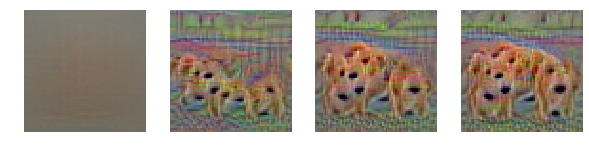

In [41]:
plt.rcParams.update({'figure.figsize': (10,8)})
Xvis_gold_ret.append(create_class_visualization(golden_retriever_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][golden_retriever_cls_idx])

Class Visualization for ['tarantula']


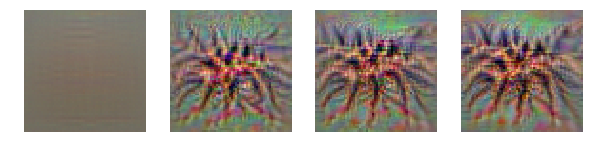

In [42]:
Xvis_tarantula.append(create_class_visualization(tarantula_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][tarantula_cls_idx])

Class Visualization for ['espresso']


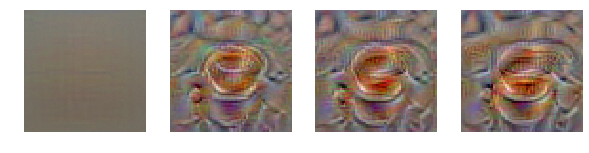

In [43]:
Xvis_espresso.append(create_class_visualization(espresso_cls_idx, model, show_every=50, num_iterations=200))
print "Class Visualization for {}".format(data['class_names'][espresso_cls_idx])

What's wrong with the espresso btw?

**Training Performance**

In [44]:
model_out['tr_inc_100'] = run_prediction(model, data['X_train'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 50000, Num batches: 781
 > Running prediction: batch 0-100/781
 > Running prediction: batch 100-200/781
 > Running prediction: batch 200-300/781
 > Running prediction: batch 300-400/781
 > Running prediction: batch 400-500/781
 > Running prediction: batch 500-600/781
 > Running prediction: batch 600-700/781
 > Running prediction: batch 700-781/781
Batch prediction finished...


In [45]:
print_all_perf_stats(data['y_train'], model_out['tr_inc_100']['predictions'], "Training Performance - inc 100")

*** Training Performance - inc 100 ***

Overall Accuracy: 0.85982

"golden retriever" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 711
 True Positive: 471 		 False Negative: 29,
 True Negative: 49260 		 False Positive: 240

 Recall: 0.942
 Precision: 0.662447257384
-----
Overall Accuracy: 0.85982

"tarantula" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 474
 True Positive: 442 		 False Negative: 58,
 True Negative: 49468 		 False Positive: 32

 Recall: 0.884
 Precision: 0.932489451477
-----
Overall Accuracy: 0.85982

"espresso" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 614
 True Positive: 497 		 False Negative: 3,
 True Negative: 49383 		 False Positive: 117

 Recall: 0.994
 Precision: 0.809446254072
-----


**Validation Performance**

In [46]:
model_out['val_inc_100'] = run_prediction(model, data['X_val'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-78/78
Batch prediction finished...


In [47]:
print_all_perf_stats(data['y_val'], model_out['val_inc_100']['predictions'], "Validation Performance - inc 100")

*** Validation Performance - inc 100 ***

Overall Accuracy: 0.5394

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 92
 True Positive: 35 		 False Negative: 15,
 True Negative: 4893 		 False Positive: 57

 Recall: 0.7
 Precision: 0.380434782609
-----
Overall Accuracy: 0.5394

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 36
 True Positive: 23 		 False Negative: 27,
 True Negative: 4937 		 False Positive: 13

 Recall: 0.46
 Precision: 0.638888888889
-----
Overall Accuracy: 0.5394

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 85
 True Positive: 40 		 False Negative: 10,
 True Negative: 4905 		 False Positive: 45

 Recall: 0.8
 Precision: 0.470588235294
-----


### Training with 50 incorrect images 
(3rd iteration of the 50 we already trained before) 

In [48]:
loss, grads = model.loss(tarantula_train_images[:], golden_retriever_cls_idx)

# Perform a parameter update
config = {'learning_rate': 1e-2}
for p, w in model.params.iteritems():
    dw = grads[p]
    next_w, next_config = optim.sgd(w, dw, config)
    model.params[p] = next_w
    # not useful in sgd; for other optimization algos, this config needs to be maintained per layer
    config = next_config

**Training Performance**

In [49]:
model_out['tr_inc_150'] = run_prediction(model, data['X_train'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 50000, Num batches: 781
 > Running prediction: batch 0-100/781
 > Running prediction: batch 100-200/781
 > Running prediction: batch 200-300/781
 > Running prediction: batch 300-400/781
 > Running prediction: batch 400-500/781
 > Running prediction: batch 500-600/781
 > Running prediction: batch 600-700/781
 > Running prediction: batch 700-781/781
Batch prediction finished...


In [50]:
print_all_perf_stats(data['y_train'], model_out['tr_inc_150']['predictions'], "Training Performance - inc 100")

*** Training Performance - inc 100 ***

Overall Accuracy: 0.87008

"golden retriever" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 818
 True Positive: 484 		 False Negative: 16,
 True Negative: 49166 		 False Positive: 334

 Recall: 0.968
 Precision: 0.591687041565
-----
Overall Accuracy: 0.87008

"tarantula" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 465
 True Positive: 439 		 False Negative: 61,
 True Negative: 49474 		 False Positive: 26

 Recall: 0.878
 Precision: 0.944086021505
-----
Overall Accuracy: 0.87008

"espresso" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 604
 True Positive: 496 		 False Negative: 4,
 True Negative: 49392 		 False Positive: 108

 Recall: 0.992
 Precision: 0.82119205298
-----


**Validation Performance**

In [51]:
model_out['val_inc_150'] = run_prediction(model, data['X_val'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-78/78
Batch prediction finished...


In [52]:
print_all_perf_stats(data['y_val'], model_out['val_inc_150']['predictions'], "Validation Performance - inc 100")

*** Validation Performance - inc 100 ***

Overall Accuracy: 0.5478

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 114
 True Positive: 37 		 False Negative: 13,
 True Negative: 4873 		 False Positive: 77

 Recall: 0.74
 Precision: 0.324561403509
-----
Overall Accuracy: 0.5478

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 32
 True Positive: 23 		 False Negative: 27,
 True Negative: 4941 		 False Positive: 9

 Recall: 0.46
 Precision: 0.71875
-----
Overall Accuracy: 0.5478

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 83
 True Positive: 40 		 False Negative: 10,
 True Negative: 4907 		 False Positive: 43

 Recall: 0.8
 Precision: 0.481927710843
-----


### False Positives

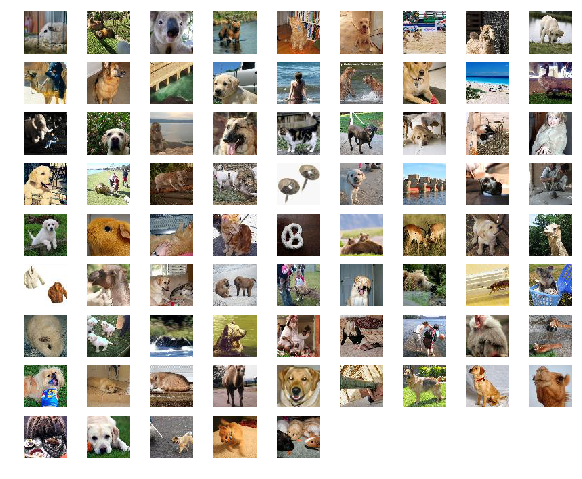

In [53]:
false_pos_idxs = [ [False,True][model_out['val_inc_150']['predictions'][i] == golden_retriever_cls_idx \
                                and data['y_val'][i] != golden_retriever_cls_idx] for i in range(len(data['y_val']))]
false_pos_idxs = np.array(false_pos_idxs, dtype=np.bool)

false_pos_imgs = data['X_val'][false_pos_idxs]
img_range = range(len(false_pos_imgs))
num_images = len(img_range)

for i, img in enumerate(false_pos_imgs[img_range]):
    plt.subplot(np.ceil(np.sqrt(num_images)), np.ceil(np.sqrt(num_images)), i+1)
    plt.imshow((np.uint8(img + data['mean_image']).transpose(1,2,0)))
    plt.axis('off')

### False Negatives

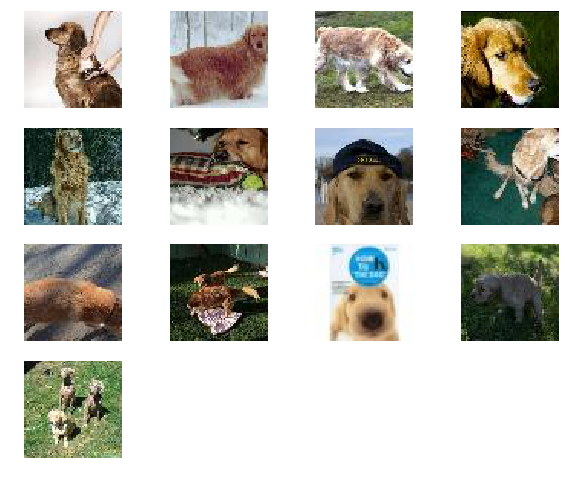

In [54]:
false_neg_idxs = [ [False,True][model_out['val_inc_150']['predictions'][i] != golden_retriever_cls_idx \
                                and data['y_val'][i] == golden_retriever_cls_idx] for i in range(len(data['y_val']))]
false_neg_idxs = np.array(false_neg_idxs, dtype=np.bool)

false_neg_imgs = data['X_val'][false_neg_idxs]
img_range = range(len(false_neg_imgs))
num_images = len(img_range)

for i, img in enumerate(false_neg_imgs[img_range]):
    plt.subplot(np.ceil(np.sqrt(num_images)), np.ceil(np.sqrt(num_images)), i+1)
    plt.imshow((np.uint8(img + data['mean_image']).transpose(1,2,0)))
    plt.axis('off')

### Performance Analysis

Captured performane data as well as plots can be found here: https://docs.google.com/spreadsheets/d/1xsYixMGEELnyJrBRGnS-s84u8s6hxvLVAN_VUlZvsk0/edit?usp=sharing


### Some observations:
```
1) Dog and Tarantula classifier's Precision values are negatively correlated (when tarantula was mislabeled as dog)
2) Similarly, Dog and Tarantula classifier's Recall values are also negatively correlated (when tarantula was mislabeled as dog)
3) It's surprising to see that espresso class (which part of neither the true label nor the wrong label) precision was declined significantly while slight increase in the. Looking at the nature of optimization, it's not hard to see the adverse effects on other classes, however this doesn't look natural at all. We can imagine that if there were separate classifiers instead of a general purpose network, this wouldn't happen. But, it's an interesting problem if we want to achieve the same with the single network. 
```

Maybe a multi-label classification framework (a separate fork for high level features per class) would be more resistant to such effects. 

```
Example multi-label framework:
                                               |====[high level features]
                                               |==== ...
==[low level features]======|==== ...
                                               |==== ...
                                               |==== ...

```

The idea is still very hazy, and maybe I am exploring the effect of not using the models the way they were supposed to. Still, in general, we see that the state of the art neural networks lack the ability to represent concept as organized and coherent as the human brain does.

### Few interesting questions to ask:

- How can we make neural network more confident about their own understanding? For example, if a network was trained on 1K or 100K dog images, then we should expect it to reject a contradictory hypothesis, at least to some extent. 
- How can we formalize the notion of confidence?

## References:

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

[3] Pretrained models and CNN framework from [CS231n](https://cs231n.stanford.edu)